In [11]:
%pip install highlight-text
import matplotlib.pyplot as plt
import pandas as pd
from highlight_text import fig_text

#Load the data

df=pd.read_html('https://fbref.com/en/matches/fff671a9/Chelsea-Bournemouth-January-14-2025-Premier-League', attrs={'id': 'shots_all'})[0]

Note: you may need to restart the kernel to use updated packages.


In [12]:
df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
              Minute             Player              Squad                 xG   
0                  7        Cole Palmer            Chelsea               0.04   
1                 10        Cole Palmer            Chelsea               0.05   
2                 13        Cole Palmer            Chelsea               0.56   
3                 22       Jadon Sancho            Chelsea               0.05   
4                 24       Noni Madueke            Chelsea               0.08   

  Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0 Unnamed: 7_level_0  \
                PSxG            Outcome           Distance          Body Part   
0               0.13              Saved               29.0          Left Foot   
1               0.00         Off Target               16.0          Left Foot   
2               0.59               Goal               13.0          Left Foot   
3               0.00            Blocked               13.0         Right Foot   
4               0.00            Blocked               16.0          Left Foot   

     Unnamed: 8_level_0            SCA 1                         SCA 2  \
                  Notes           Player        Event           Player   
0  Free kick, Deflected   Enzo Fernández       Fouled   Moisés Caicedo   
1                   NaN     Jadon Sancho  Pass (Live)      Cole Palmer   
2                   NaN  Nicolas Jackson  Pass (Live)  Nicolas Jackson   
3                   NaN   Enzo Fernández  Pass (Live)   Moisés Caicedo   
4                   NaN   Enzo Fernández  Pass (Live)   Marc Cucurella   

                
         Event  
0  Pass (Live)  
1  Pass (Live)  
2      Take-On  
3  Pass (Live)  
4  Pass (Live)

In [13]:
#Clean the data
df = df.drop(columns=[x for x in df.columns if 'SCA' in x[0]])

df.columns = df.columns.droplevel(0)
df.columns

Index(['Minute', 'Player', 'Squad', 'xG', 'PSxG', 'Outcome', 'Distance',
       'Body Part', 'Notes'],
      dtype='object')

In [14]:
# And filter the columns we need
df = df[['Squad', 'Player', 'Minute', 'xG', 'Outcome']]
df.head()

,Squad,Player,Minute,xG,Outcome
0,Chelsea,Cole Palmer,7,0.04,Saved
1,Chelsea,Cole Palmer,10,0.05,Off Target
2,Chelsea,Cole Palmer,13,0.56,Goal
3,Chelsea,Jadon Sancho,22,0.05,Blocked
4,Chelsea,Noni Madueke,24,0.08,Blocked


In [15]:
# Now let's create a column for the cumulative xG for each team
df['cumulative_xG'] = df.groupby('Squad')['xG'].cumsum()
df

,Squad,Player,Minute,xG,Outcome,cumulative_xG
0,Chelsea,Cole Palmer,7,0.04,Saved,0.04
1,Chelsea,Cole Palmer,10,0.05,Off Target,0.09
2,Chelsea,Cole Palmer,13,0.56,Goal,0.65
3,Chelsea,Jadon Sancho,22,0.05,Blocked,0.70
4,Chelsea,Noni Madueke,24,0.08,Blocked,0.78
5,Chelsea,Enzo Fernández,29,0.05,Saved,0.83
6,Chelsea,Nicolas Jackson,33,0.27,Off Target,1.10
7,Bournemouth,Justin Kluivert,37,0.16,Woodwork,0.16
8,Chelsea,Nicolas Jackson,37,0.07,Woodwork,1.17
9,Chelsea,Cole Palmer,39,0.06,Saved,1.23


In [16]:
# We also need to get the minute in a format that we can use to plot the flow chart
# Let's first drop the nan values that FBREF uses as a divider
# So let's drop that nan row and then cast to an int
df = df.dropna(subset=['Minute'])
df['Minute']

0        7
1       10
2       13
3       22
4       24
5       29
6       33
7       37
8       37
9       39
10      43
11      44
12      44
13      44
15      46
16      48
17      50
18      58
19      60
20      62
21      65
22      65
23      68
24      69
25      76
26      77
27      85
28      88
29    90+2
30    90+3
31    90+3
32    90+5
33    90+9
Name: Minute, dtype: object

In [17]:
# You might also see that some minutes have a '+' in them, which means that the minute is the minute of the first half plus the minute of the second half
# Let's also create a column that shows which half the minute is 
# (since we can have a 46th minute in the first half and a 46th minute in the second half)
df['half'] = df['Minute'].apply(lambda x: 1 if int(x.split('+')[0]) <= 45 else 2)
df

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_76706/3340019740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['half'] = df['Minute'].apply(lambda x: 1 if int(x.split('+')[0]) <= 45 else 2)


,Squad,Player,Minute,xG,Outcome,cumulative_xG,half
0,Chelsea,Cole Palmer,7,0.04,Saved,0.04,1
1,Chelsea,Cole Palmer,10,0.05,Off Target,0.09,1
2,Chelsea,Cole Palmer,13,0.56,Goal,0.65,1
3,Chelsea,Jadon Sancho,22,0.05,Blocked,0.70,1
4,Chelsea,Noni Madueke,24,0.08,Blocked,0.78,1
5,Chelsea,Enzo Fernández,29,0.05,Saved,0.83,1
6,Chelsea,Nicolas Jackson,33,0.27,Off Target,1.10,1
7,Bournemouth,Justin Kluivert,37,0.16,Woodwork,0.16,1
8,Chelsea,Nicolas Jackson,37,0.07,Woodwork,1.17,1
9,Chelsea,Cole Palmer,39,0.06,Saved,1.23,1


In [18]:
# Now let's adjust the minute to add the minutes if there is a '+' in the minute
df['Minute'] = df['Minute'].apply(lambda x: sum([int(y) for y in x.split('+')]))
df['Minute']

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_76706/3789240490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Minute'] = df['Minute'].apply(lambda x: sum([int(y) for y in x.split('+')]))


0      7
1     10
2     13
3     22
4     24
5     29
6     33
7     37
8     37
9     39
10    43
11    44
12    44
13    44
15    46
16    48
17    50
18    58
19    60
20    62
21    65
22    65
23    68
24    69
25    76
26    77
27    85
28    88
29    92
30    93
31    93
32    95
33    99
Name: Minute, dtype: int64

Text(0.1, 0.0, '@hazanserifli/Chelsea_Bournemouth_Analysis')

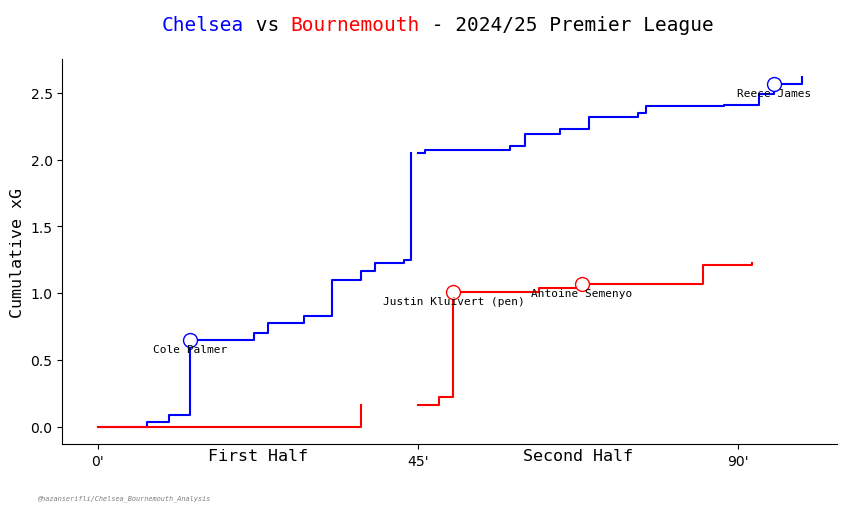

In [19]:


# Update the team colors
chelsea_color = 'blue'
bournemouth_color = 'red'

fig, ax = plt.subplots(figsize=(10, 5))

# Plot the xG for each team by half
for team in df['Squad'].unique():
    team_df = df[df['Squad'] == team]
    
    # Add a 0 xG row at the start of the match
    team_df = pd.concat([pd.DataFrame({'Squad': team, 'Minute': 0, 'xG': 0, 'Outcome': 'Goal', 'cumulative_xG': 0, 'half': 1}, index=[0]), team_df])
    
    # Add a row at the beginning of the second half
    team_df = pd.concat([team_df[team_df['half'] == 1], 
                         pd.DataFrame({'Squad': team, 'Minute': 45, 'xG': 0, 'Outcome': 'Goal', 
                                       'cumulative_xG': team_df[team_df['half'] == 1]['cumulative_xG'].iloc[-1], 
                                       'half': 2}, index=[0]), 
                         team_df[team_df['half'] == 2]])
    
    for half in team_df['half'].unique():
        half_df = team_df[team_df['half'] == half]
        ax.plot(
            half_df['Minute'], 
            half_df['cumulative_xG'], 
            label=team, 
            drawstyle='steps-post',
            c=chelsea_color if team == 'Chelsea' else bournemouth_color
        )

# Add scatter plot to show goals
for team in df['Squad'].unique():
    team_df = df[(df['Squad'] == team) & (df['Outcome'] == 'Goal')].to_dict(orient='records')
    for x in team_df:
        ax.scatter(
            x['Minute'], 
            x['cumulative_xG'], 
            c='white',
            edgecolor=chelsea_color if team == 'Chelsea' else bournemouth_color,
            s=100,
            zorder=5
        )
        
        # Add label for goals
        ax.text(
            x['Minute'], 
            x['cumulative_xG'] - .07, 
            x['Player'], 
            ha='center', 
            va='center', 
            fontfamily='monospace', 
            fontsize=8,
            zorder=10
        )

# Label the x-axis
ax.set_xticks([0, 45, 90])
ax.set_xticklabels(['0\'', '45\'', '90\''])

# Add "First Half" and "Second Half" labels
ax.text(22.5, -.25, 'First Half', ha='center', fontfamily='monospace', fontsize=12)
ax.text(67.5, -.25, 'Second Half', ha='center', fontfamily='monospace', fontsize=12)

# Label the y-axis
ax.set_ylabel('Cumulative xG', fontfamily='monospace', fontsize=12)

# Remove unnecessary spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Highlight text for the title
fig_text(
    0.5,
    0.95,
    '<Chelsea> vs <Bournemouth> - 2024/25 Premier League', 
    fontsize=14, 
    ha='center', 
    va='center', 
    ax=ax, 
    fontfamily='monospace', 
    highlight_textprops=[{'color': chelsea_color}, {'color': bournemouth_color}]
)

# Add attribution at the bottom-left
fig.text(
    0.1, 
    0.00, 
    '@hazanserifli/Chelsea_Bournemouth_Analysis', 
    fontsize=5, 
    fontstyle='oblique', 
    fontfamily='monospace', 
    color='gray'
)